# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import emcee
from scipy.stats import norm, uniform, truncnorm
from multiprocessing import Pool
from scipy.optimize import least_squares
from scipy.stats import binned_statistic
import corner
import astropy.units as u
from astropy.timeseries import LombScargle
import arviz as az
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

# Loading sage 
import sys
import os
sys.path.append('/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/sage_output')
from sage import sage_class

# Functions

In [ ]:
# defining MCMC funcs (log prior, log likelihood, log probability)
def lnprior(params,priors):
    lp = 0.0
    for par, pr in zip(params, priors):
        lp += pr.logpdf(par)
    return lp

def eval_sage(params, time, args):
    # disintegrating the params to make it usable in sage. 
    #% Spots
    spot_long= []
    spot_lat=[]
    spot_size= []
    for spot_param, spot_list in zip(['lat', 'long', 'size'], [spot_lat, spot_long, spot_size]):
        for num in range(args['spotnumber']):
            param_name = f'spot{num+1}_{spot_param}'
            if param_name in args['var_param_list']:spot_list.append(params[args['var_param_list'].index(param_name)])
            elif param_name in args['fix_param_list']:spot_list.append(args['fix_param_values'][args['fix_param_list'].index(param_name)])

    #% All others
    add_param_values = {'offset': 0.,'jitter': 0.,'Prot': 0.,'sp_ctrst': 0.}

    # Update values from args
    for key in add_param_values:
        if key in args['var_param_list']:
            add_param_values[key] = params[args['var_param_list'].index(key)]
        elif key in args['fix_param_list']:
            add_param_values[key] = args['fix_param_values'][args['fix_param_list'].index(key)]

    # Extract final values
    offset = add_param_values['offset']
    jitt = add_param_values['jitter']
    prot = add_param_values['Prot']
    spotcontrast = add_param_values['sp_ctrst']

    # inclination= params[-1] # inclination of star
    inclination=90.

    # defining wavelength params
    wavelength= [5000]  # cal wavelength [pretty much useless]
    flux_hot=[1]        # immaculate photosphere
    flux_cold= [1 * spotcontrast]   #[0.2691] # contrast

    u1= 0.63
    u2= 0.15

    stellar_params=[0.0488,                                    # Radius-ratio   
                18.79,                                     # scaled semi-major axis 
                u1,                                        # U1
                u2,                                        # U2
                0.0,                                       # cosine of angular distance
                0.0,                                       # Intensity profile 
                inclination]                               

    planet_pixel_size= 10

    ve=(2*np.pi*0.744*696340)/(prot*24*3600)

    model_lightcurve = np.empty(len(time))

    for i, ti in enumerate(time):
        
        phase_roti = ((2*np.pi)/prot) * (ti - time[0])

        star = sage_class(stellar_params, planet_pixel_size, wavelength, flux_hot, flux_cold, 
                spot_lat, spot_long, spot_size, ve, args['spotnumber'], 'multi-color', 5000, phases_rot=[np.rad2deg(phase_roti) * u.deg])

        flux_norm, contamination_factors, star_map= star.rotate_star()

        model_lightcurve[i] = flux_norm 

    return model_lightcurve + offset, jitt # delete this when you are done with the code.

def ls_residual(params, time, flux, flux_err, args):

    mdl = eval_sage(params, time, args)[0]

    residual = (mdl - flux)/flux_err

    residual[(np.isnan(residual) | np.isinf(residual))] = 0.

    return residual

def lnlike(params, time, flux, flux_err, args):

    mdl, jitt = eval_sage(params, time, args)

    sigma2= flux_err**2 + mdl**2 * np.exp(2*jitt) # the corrected error in flux.

    return -0.5 * np.sum((flux - mdl)**2/sigma2 + np.log(sigma2) ) 

def lnprob(params, priors, day, flux, flux_err, args):
    lp = lnprior(params, priors)
    if np.isfinite(lp):
        ll = lnlike(params, day, flux, flux_err, args)
        if (not np.isnan(ll)):
            return lp+ll
        else:
            return -np.inf
    else:
        return -np.inf

# Defining parameters

In [3]:
# Defining sectors to use and LCs for each sector
sectors_dic = {1:[1,2], 27:[1,2]}
sectors = list(sectors_dic.keys())

#Defining relevant directories
output_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/sage_output/AU_Mic/'
input_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/AUMic_data/Formatted_TESS'

#Defining dictionary with planet information -> to remove their transits
planet_propdic = {}
planet_propdic['AUMicb']={}
planet_propdic['AUMicb']['T0'] = 2458330.39051 #BJD
planet_propdic['AUMicb']['period'] = 8.463000  #days
planet_propdic['AUMicb']['T14'] = 3.4927/24    #days

planet_propdic['AUMicc']={}
planet_propdic['AUMicc']['T0'] = 2458342.2240 #BJD
planet_propdic['AUMicc']['period'] = 18.85969  #days
planet_propdic['AUMicc']['T14'] = 4.236/24    #days

planet_list = list(planet_propdic.keys())

#Defining the flare sigma-clipping thresholds
sigma_dic = {1:[1.5, 2.5], 27:[1.5, 1.5]}

# Defining rolling median function
def rolling_median(data, window):
    half_window = window // 2
    medians = np.full_like(data, np.nan)
    for i in range(half_window, len(data) - half_window):
        medians[i] = np.median(data[i - half_window:i + half_window + 1])
    return medians

#Defining number of points to bin each LC to
nbins = 500

#Defining dictionary to store output from pre-processing of each LC
output_dic = {}

#Defining fitting related settings
numcores = 1

fitting_method = 'ls'
processing_method = 'use'
#Defining least squares settings

#Defining MCMC settings
nsteps = 5
nburn=3

#Initial guesses
#Prot in days
#lat, long, size in degrees
guess_dic = {
        'sector_1':{
            'LC_1':{
                'spot1_lat': {'vary':True, 'guess':-30, 'bounds':[-50, -10]},
                'spot2_lat': {'vary':False, 'guess':40, 'bounds':[20, 60]},
                'spot1_long': {'vary':True, 'guess':-100, 'bounds':[-120, -80]},
                'spot2_long': {'vary':True, 'guess':80, 'bounds':[60, 100]},
                'spot1_size': {'vary':False, 'guess':10, 'bounds':[5, 15]},
                'spot2_size': {'vary':True, 'guess':15, 'bounds':[10, 20]},
                'offset': {'vary':True, 'guess':0.0187, 'bounds':[0.001, 0.1]},
                'jitter': {'vary':False, 'guess':-10, 'bounds':[-12, 10]},
                'Prot': {'vary':True, 'guess':'LS'},
                'sp_ctrst': {'vary':False, 'guess':0.7,'bounds':[0.4, 0.8]},
            },
            'LC_2':{
                'spot1_lat': {'vary':True, 'guess':-30, 'bounds':[-50, -10]},
                'spot2_lat': {'vary':False, 'guess':40, 'bounds':[20, 60]},
                'spot1_long': {'vary':True, 'guess':-100, 'bounds':[-120, -80]},
                'spot2_long': {'vary':True, 'guess':80, 'bounds':[60, 100]},
                'spot1_size': {'vary':False, 'guess':10, 'bounds':[5, 15]},
                'spot2_size': {'vary':True, 'guess':15, 'bounds':[10, 20]},
                'offset': {'vary':True, 'guess':0.0187, 'bounds':[0.001, 0.5]},
                'jitter': {'vary':False, 'guess':-10, 'bounds':[-12, 10]},
                'Prot': {'vary':True, 'guess':'LS'},
                'sp_ctrst': {'vary':False, 'guess':0.7,'bounds':[0.4, 0.8]},
            },
        },
        'sector_27':{
            'LC_1':{
                'spot1_lat': {'vary':True, 'guess':-30, 'bounds':[-50, -10]},
                'spot2_lat': {'vary':False, 'guess':40, 'bounds':[20, 60]},
                'spot1_long': {'vary':True, 'guess':-100, 'bounds':[-120, -80]},
                'spot2_long': {'vary':True, 'guess':80, 'bounds':[60, 100]},
                'spot1_size': {'vary':False, 'guess':10, 'bounds':[5, 15]},
                'spot2_size': {'vary':True, 'guess':15, 'bounds':[10, 20]},
                'offset': {'vary':True, 'guess':0.0187, 'bounds':[0.001, 0.5]},
                'jitter': {'vary':False, 'guess':-10, 'bounds':[-12, 10]},
                'Prot': {'vary':True, 'guess':'LS'},
                'sp_ctrst': {'vary':False, 'guess':0.7,'bounds':[0.4, 0.8]},
            },
            'LC_2':{
                'spot1_lat': {'vary':True, 'guess':-30, 'bounds':[-50, -10]},
                'spot2_lat': {'vary':False, 'guess':40, 'bounds':[20, 60]},
                'spot1_long': {'vary':True, 'guess':-100, 'bounds':[-120, -80]},
                'spot2_long': {'vary':True, 'guess':80, 'bounds':[60, 100]},
                'spot1_size': {'vary':False, 'guess':10, 'bounds':[5, 15]},
                'spot2_size': {'vary':True, 'guess':15, 'bounds':[10, 20]},
                'offset': {'vary':True, 'guess':0.0187, 'bounds':[0.001, 0.5]},
                'jitter': {'vary':False, 'guess':-10, 'bounds':[-12, 10]},
                'Prot': {'vary':True, 'guess':'LS'},
                'sp_ctrst': {'vary':False, 'guess':0.7,'bounds':[0.4, 0.8]},
            },
        }
}

#Priors
priors_dic = {
        'sector_1':{
            'LC_1':{
                'spot1_lat': {'type':'uf', 'min':-90, 'max':90},
                # 'spot2_lat': {'type':'uf', 'min':-90, 'max':90},
                'spot1_long': {'type':'uf', 'min':-180, 'max':180},
                'spot2_long': {'type':'uf', 'min':-180, 'max':180},
                # 'spot1_size': {'type':'uf', 'min':0, 'max':90},
                'spot2_size': {'type':'uf', 'min':0, 'max':90},
                'offset': {'type':'uf', 'min':-1.5, 'max':2.5},
                # 'jitter': {'type':'uf', 'min':-15, 'max':15},
                'Prot': {'type':'LS'}
            },
            'LC_2':{
                'spot1_lat': {'type':'uf', 'min':-90, 'max':90},
                # 'spot2_lat': {'type':'uf', 'min':-90, 'max':90},
                'spot1_long': {'type':'uf', 'min':-180, 'max':180},
                'spot2_long': {'type':'uf', 'min':-180, 'max':180},
                # 'spot1_size': {'type':'uf', 'min':0, 'max':90},
                'spot2_size': {'type':'uf', 'min':0, 'max':90},
                'offset': {'type':'uf', 'min':-1.5, 'max':2.5},
                # 'jitter': {'type':'uf', 'min':-15, 'max':15},
                'Prot': {'type':'LS'}
            },
        },
        'sector_27':{
            'LC_1':{
                'spot1_lat': {'type':'uf', 'min':-90, 'max':90},
                # 'spot2_lat': {'type':'uf', 'min':-90, 'max':90},
                'spot1_long': {'type':'uf', 'min':-180, 'max':180},
                'spot2_long': {'type':'uf', 'min':-180, 'max':180},
                # 'spot1_size': {'type':'uf', 'min':0, 'max':90},
                'spot2_size': {'type':'uf', 'min':0, 'max':90},
                'offset': {'type':'uf', 'min':-1.5, 'max':2.5},
                # 'jitter': {'type':'uf', 'min':-15, 'max':15},
                'Prot': {'type':'LS'}
            },
            'LC_2':{
                'spot1_lat': {'type':'uf', 'min':-90, 'max':90},
                # 'spot2_lat': {'type':'uf', 'min':-90, 'max':90},
                'spot1_long': {'type':'uf', 'min':-180, 'max':180},
                'spot2_long': {'type':'uf', 'min':-180, 'max':180},
                # 'spot1_size': {'type':'uf', 'min':0, 'max':90},
                'spot2_size': {'type':'uf', 'min':0, 'max':90},
                'offset': {'type':'uf', 'min':-1.5, 'max':2.5},
                # 'jitter': {'type':'uf', 'min':-15, 'max':15},
                'Prot': {'type':'LS'}
            },
        }
}

# Retrieving data

SECTOR N.1, LC N.1
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


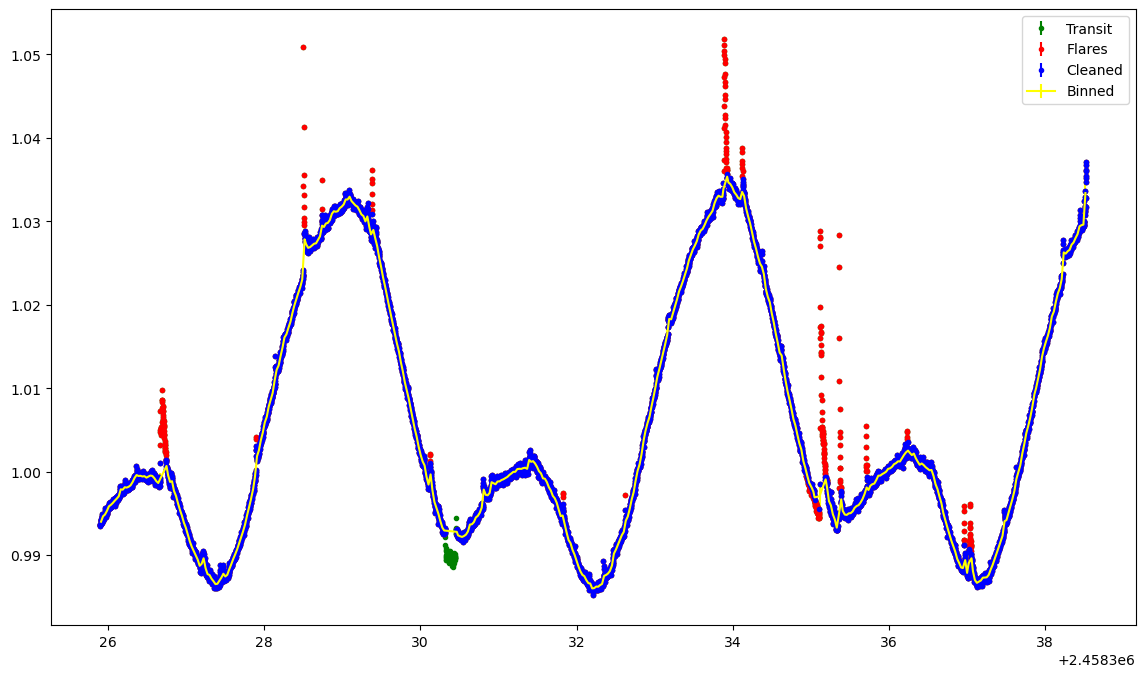

SECTOR N.1, LC N.2
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


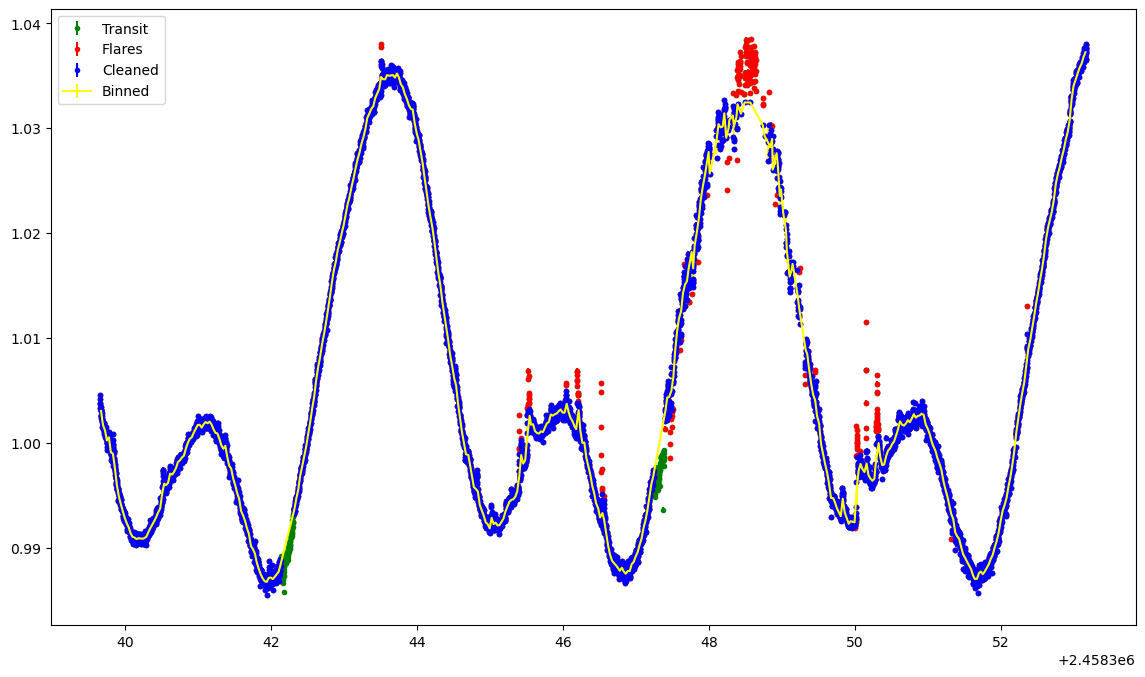

SECTOR N.27, LC N.1
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


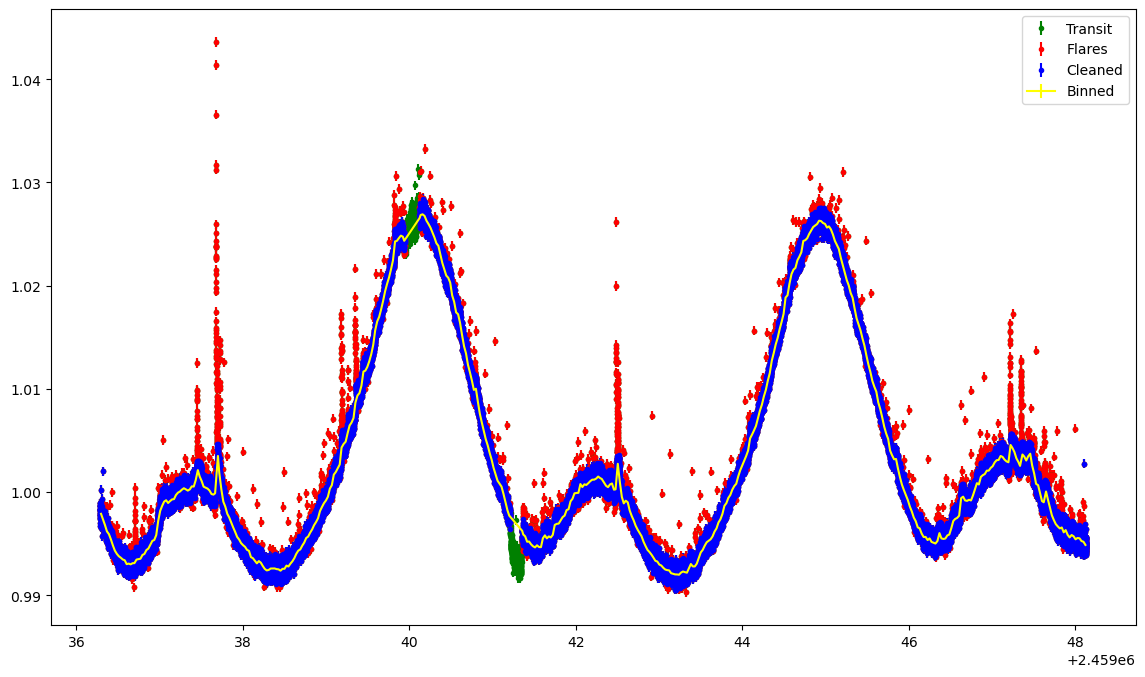

SECTOR N.27, LC N.2
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


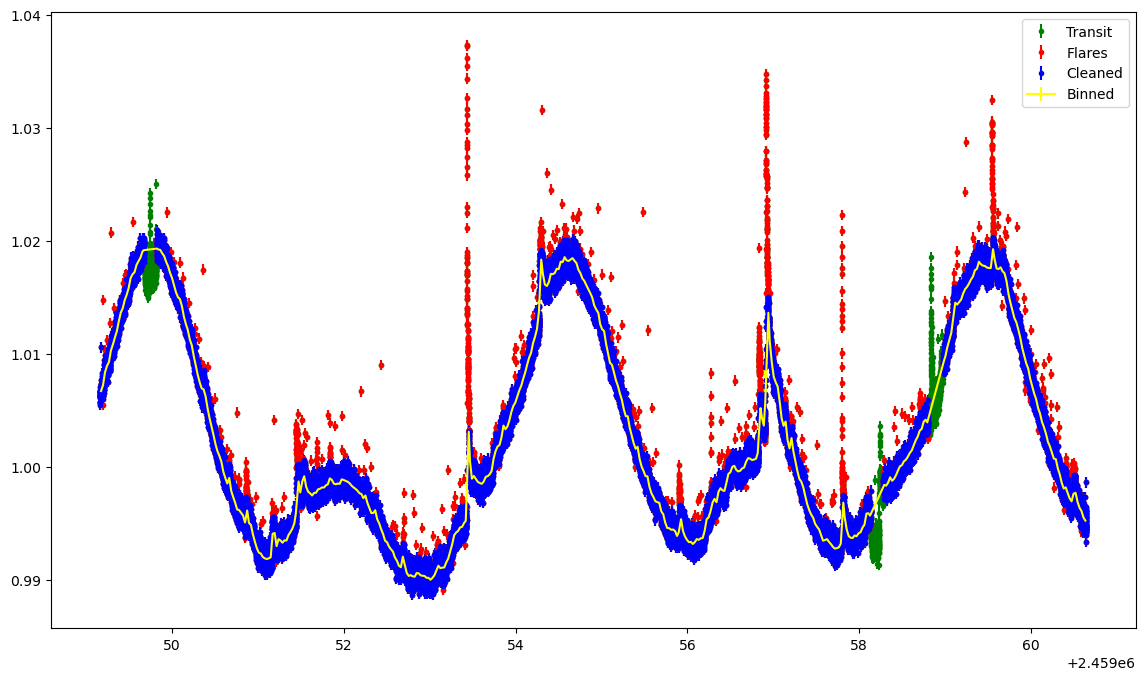

In [4]:
#Looping over sectors
for sector in sectors:
    #Getting sector name
    sector_name = f'sector_{sector}'
    sector_dir = output_dir+'/'+sector_name
    if not os.path.isdir(sector_dir):os.makedirs(sector_dir)
    output_dic[sector_name]={}

    #Looping over each transit
    for transitidx, transitnum in enumerate(sectors_dic[sector]):
        
        #Getting transit name
        LC_name = f'LC_{transitnum}'
        LC_dir = sector_dir+'/'+LC_name
        if not os.path.isdir(LC_dir):os.makedirs(LC_dir)
        output_dic[sector_name][LC_name]={}

        #Print
        print(f'SECTOR N.{sector}, LC N.{transitnum}')
        plt.figure(figsize=[14, 8])

        #Retrieving data
        print('RETRIEVING DATA')
        pd_data= pd.read_csv(input_dir + f'/Sector_{sector}/LC_{sector}_{transitnum}.csv')

        #Retrieving raw data
        mask_finite_flux = np.isfinite(pd_data['flux'])
        t = pd_data['time'][mask_finite_flux] + 2457000 #converting TESS BJD to BJD
        flux = pd_data['flux'][mask_finite_flux]
        flux_err = pd_data['flux_err'][mask_finite_flux]

        #Removing transit of planet considered   
        print('REMOVING TRANSIT')
        #% Defining mask to figure out the timestamps of in-transit exposures
        IT_mask = np.zeros(len(t), dtype=bool)

        #% Looping over all known planets in the system just in case
        for planet in planet_list:
            #% Getting planet properties 
            planet_dic = planet_propdic[planet]

            #% Number of transits that happened during epoch considered
            n_low  = np.round((min(t) - planet_dic['T0'])/planet_dic['period'], 0)
            n_high = np.round((max(t) - planet_dic['T0'])/planet_dic['period'], 0)
            #% Predicting transit midpoints during epoch considered
            predicted_T0s = planet_dic['T0'] + np.arange(n_low, n_high+1, 1)*planet_dic['period']

            #%Looping over all transits in epoch considered and updating mask to remove them
            for predicted_T0 in predicted_T0s:
                IT_mask |= (t>predicted_T0-(planet_dic['T14']/2)) & (t<predicted_T0+(planet_dic['T14']/2))

        #Plotting transits before and after
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='green', label='Transit')
        t = t[~IT_mask]
        flux = flux[~IT_mask]
        flux_err = flux_err[~IT_mask]

        #Removing flares
        print('REMOVING FLARES')

        #% compute rolling median of the LC
        rolling_med = rolling_median(flux, window=300)

        #% "Normalize" LC
        raw_norm_flux = flux/rolling_med
        norm_flux = raw_norm_flux[~np.isnan(raw_norm_flux)]

        #% Sigma clip to remove flares
        sigma=sigma_dic[sector][transitidx]
        flare_mask = ((raw_norm_flux < np.median(norm_flux) - sigma*np.std(norm_flux)) | (raw_norm_flux > np.median(norm_flux) + sigma*np.std(norm_flux)))  

        #Masking points
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='red', label='Flares')
        t=t[~flare_mask]
        flux=flux[~flare_mask]
        flux_err=flux_err[~flare_mask]


        #Binning data to make MCMC easier
        print('BINNING DATA')
        binned_t = binned_statistic(t, t, statistic='mean', bins=nbins)[0]
        binned_flux = binned_statistic(t, flux, statistic='mean', bins=nbins)[0]
        binned_flux_err = binned_statistic(t, flux, statistic='std', bins=nbins)[0]

        #Final cleaned result
        binned_flux = binned_flux[~np.isnan(binned_t)]
        binned_flux_err = binned_flux_err[~np.isnan(binned_t)]
        binned_t = binned_t[~np.isnan(binned_t)]
        output_dic[sector_name][LC_name]['t'] = binned_t
        output_dic[sector_name][LC_name]['flux'] = binned_flux
        output_dic[sector_name][LC_name]['flux_err'] = binned_flux_err
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='blue', label='Cleaned')
        plt.errorbar(binned_t, binned_flux, yerr=binned_flux_err, color='yellow', linestyle='-', label='Binned')        
        plt.legend()
        plt.savefig(LC_dir+'/input_LC.pdf')
        plt.show()
        plt.close()


# Fitting data

In [ ]:
for sector in sectors:
    sector_name = f'sector_{sector}'
    sector_dir = output_dir+'/'+sector_name
    #Looping over each transit
    for transitidx, transitnum in enumerate(sectors_dic[sector]):
        LC_name = f'LC_{transitnum}'
        LC_dir = sector_dir+'/'+LC_name
        print(f'SECTOR N.{sector}, LC N.{transitnum}')

        #Loading data
        local_guess_dic = guess_dic[sector_name][LC_name]
        local_priors_dic = priors_dic[sector_name][LC_name]
        local_output_dic = output_dic[sector_name][LC_name]

        #Inirtializing lists
        spot_params=[]
        spot_priors= []
        spot_labels= []

        #Finding the number of spots
        spotnames = []
        for key in local_guess_dic.keys():
            if ('spot' in key):spotnames.append(key.split('_')[0])
        spotnumber = len(np.unique(spotnames))

        #Parameter check
        for param in local_guess_dic.keys():
            if (local_guess_dic[param]['vary']) and (param not in local_priors_dic.keys()):
                raise ValueError(f"{param} is free and must therefore be in priors_dic.")
            if (not local_guess_dic[param]['vary']) and (param in local_priors_dic.keys()):
                raise ValueError(f"{param} is fixed and must therefore not be in priors_dic.")
        
        #Initiallizing important lists
        var_param_list = [key for key in local_guess_dic.keys() if local_guess_dic[key]['vary']]
        fix_param_list = [key for key in local_guess_dic.keys() if not local_guess_dic[key]['vary']]
        fix_param_values = [local_guess_dic[key]['guess'] for key in fix_param_list]
        add_args={}
        add_args['var_param_list'] = var_param_list
        add_args['fix_param_list'] = fix_param_list
        add_args['fix_param_values'] = fix_param_values
        add_args['spotnumber'] = spotnumber
            
        #Prot specific check
        if ('Prot' not in var_param_list) and ('Prot' not in fix_param_list):
            raise ValueError('Rotation period must be fixed or free to continue')
        
        #Spot size and contrast warning
        for param in var_param_list:
            if ('sp_ctrst' in var_param_list) and ('_size' in param):
                print('WARNING: Spot size and contrast are both free parameters. This is not recommended.')
                break

        for num in range(spotnumber):
            for param in ['lat', 'long', 'size']:
                if f'spot{num+1}_{param}' in var_param_list:
                    #Adding parameter
                    spot_params.extend([local_guess_dic[f'spot{num+1}_{param}']['guess']])
                    #Adding priors
                    if local_priors_dic[f'spot{num+1}_{param}']['type'] == 'uf':spot_priors.extend([uniform(local_priors_dic[f'spot{num+1}_{param}']['min'], local_priors_dic[f'spot{num+1}_{param}']['max']-local_priors_dic[f'spot{num+1}_{param}']['min'])])
                    elif local_priors_dic[f'spot{num+1}_{param}']['type'] == 'gauss':spot_priors.extend([norm(loc=local_priors_dic[f'spot{num+1}_{param}']['val'], scale=local_priors_dic[f'spot{num+1}_{param}']['s_val'])])
                    else:raise ValueError(f"Prior type {local_priors_dic[f'spot{num+1}_{param}']['type']} not recognized.")
                    #Adding labels
                    spot_labels.extend([f'spot{num+1}_{param}'])

        #Compute Lomb-Scargle periodogram - only if we fit period and use LS to initialize it
        min_period = 0.5
        max_period = 10.0
        frequency = np.linspace(1/max_period, 1/min_period, 10000)
        ls = LombScargle(binned_t, binned_flux)
        power = ls.power(frequency)
        best_frequency = frequency[np.argmax(power)]
        best_period = 1 / best_frequency
        if ('Prot' in fix_param_list) and (local_guess_dic['Prot']['guess'] == 'LS'):
            add_args['fix_param_values'][fix_param_list.index('Prot')]=best_period
        
        params= spot_params
        priors = spot_priors
        for param in ['offset', 'jitter', 'Prot', 'sp_ctrst']:
            if param in var_param_list:
                if (param == 'Prot') and (local_guess_dic['Prot']['guess'] == 'LS') and (local_priors_dic['Prot']['type'] == 'LS'):
                    params.append(best_period)
                    priors.append(norm(loc=best_period, scale=.2))
                else:
                    params.append(local_guess_dic[param]['guess'])
                    if local_priors_dic[param]['type'] == 'uf':priors.append(uniform(local_priors_dic[param]['min'], local_priors_dic[param]['max']-local_priors_dic[param]['min']))
                    elif local_priors_dic[param]['type'] == 'gauss':priors.append(norm(loc=local_priors_dic[param]['val'], scale=local_priors_dic[param]['s_val']))
                    else:raise ValueError(f"Prior type {local_priors_dic[param]['type']} not recognized.")
                spot_labels.append(param)

        #Actually fitting the data
        print('FITTING')
        if fitting_method == 'ls':
            print('Fitting with least squares')
            # Run least-squares optimization
            result = least_squares(ls_residual, params, args=(local_output_dic['t'],local_output_dic['flux'],local_output_dic['flux_err'], add_args))

            # Best-fit parameters
            best_fit_params = result.x
            print("Best-fit parameters:")
            print('\n')
            for best_par_val, best_par_name in zip(best_fit_params, add_args['var_param_list']):
                print(f'{best_par_name} : {best_par_val}')
                print('\n')

        elif fitting_method == 'mcmc':
            if processing_method == 'use': 
                print('DEFINING PRIORS')
                ndim, nwalkers = len(priors), len(priors)*5
                pos = np.zeros((nwalkers, ndim), dtype=float)
                for i in range(ndim):
                    if var_param_list[i]=='Prot':pos[:, i] = np.random.normal(loc=best_period, scale=1., size=nwalkers)
                    else:pos[:, i] = np.random.uniform(low=local_guess_dic[var_param_list[i]]['bounds'][0], high=local_guess_dic[var_param_list[i]]['bounds'][1], size=nwalkers)
                for position in pos:
                    assert np.isfinite(lnprior(position,priors)), f"lnprior of parameters: {position} is not finite"

                fig,ax = plt.subplots(1,ndim, figsize=(15,5))
                ax = ax.reshape(-1)

                for i,pr in enumerate(priors):
                    ax[i].hist(pr.rvs(100000), bins=100)
                    ax[i].axvline(position[i],color="red")
                    ax[i].set_xlabel(spot_labels[i])
                    plt.tight_layout()
                plt.show()

                print('STARTING MCMC')
                if numcores > 1:
                    pool_proc = Pool(processes=numcores)
                    sampler = emcee.EnsembleSampler(nwalkers, 
                                                    ndim, 
                                                    lnprob, 
                                                    args=(priors,local_output_dic['t'],local_output_dic['flux'],local_output_dic['flux_err'], add_args),
                                                    pool = pool_proc)
                    pool_proc.close()

                else:
                    sampler = emcee.EnsembleSampler(nwalkers, 
                                                    ndim, 
                                                    lnprob, 
                                                    args=(priors,local_output_dic['t'],local_output_dic['flux'],local_output_dic['flux_err'], add_args))


                sampler.run_mcmc(pos, nsteps, progress=True)
                chain=sampler.chain

                # Storing chains
                np.save(LC_dir+'/chains.npy', chain)

            elif processing_method == 'reuse':
                ndim, nwalkers = len(priors), len(priors)*5
                chain = np.load(LC_dir+'/chains.npy')
                old_nwalkers, old_nsteps, old_ndim = chain.shape
                for old_val, new_val, name in zip([old_nwalkers, old_nsteps, old_ndim],[nwalkers, nsteps, ndim],['walkers','steps','dimensions']):
                    if old_val != new_val:
                        raise ValueError(f'Incoherent number of {name}. Old is {old_val}, new is {new_val}. Cannot go further.')

            # Plotting each chain
            for idx, label in enumerate(spot_labels):
                #Initialize plot
                fig, ax = plt.subplots(figsize=[14, 4])
                #Loop over walkers
                for iwalk in range(nwalkers):
                    ax.plot(np.arange(nburn), chain[iwalk, :nburn, idx], alpha=0.5, color="red")
                    ax.plot(np.arange(nburn, nsteps), chain[iwalk, nburn:, idx], alpha=0.5, color="blue")
                
                ax.axhline(np.median(chain[:, :, idx]), color='black', linestyle='dashed')
                HDI=az.hdi(chain[:, :, idx].flatten(), hdi_prob=.68)
                for val in HDI:ax.axhline(val, color='black', linestyle='dotted')

                ax.set_title(f"MCMC Chains for {label}")
                ax.set_xlabel("Step")
                ax.set_ylabel(label)
                plt.savefig(LC_dir+'/Chain_'+str(label)+'.pdf')
                plt.close()

            #Burning and merging chains
            chain = chain[:, nburn:, :]
            chain = np.reshape(chain, (chain.shape[0]*chain.shape[1], chain.shape[2]))

            # Plotting the corner plot
            fig = corner.corner(chain, labels=spot_labels)
            plt.savefig(LC_dir+'/corner.pdf')
            plt.close()
        
        else:
            raise ValueError(f"Fitting method {fitting_method} not recognized. Please use 'ls' or 'mcmc'.")


SECTOR N.1, LC N.1
FITTING
Fitting with least squares
Best-fit parameters:


spot1_lat : -30.0


spot1_long : -67.07904483562979


spot2_long : 76.39392799017891


spot2_size : 14.999999999999996


offset : 0.025263180629229495


Prot : 4.867210357570881


SECTOR N.1, LC N.2
FITTING
Fitting with least squares
Best-fit parameters:


spot1_lat : -30.0


spot1_long : -100.00000000383181


spot2_long : 79.99999802602174


spot2_size : 15.0


offset : 0.024584938319623627


Prot : -123.4317151467237


SECTOR N.27, LC N.1
FITTING
Fitting with least squares
Best-fit parameters:


spot1_lat : -30.0


spot1_long : -100.0000000272464


spot2_long : 80.00000000004725


spot2_size : 14.99867475364641


offset : 0.019838601012495037


Prot : -123.38268448522813


SECTOR N.27, LC N.2
FITTING
Fitting with least squares
Best-fit parameters:


spot1_lat : -30.0


spot1_long : -99.9999999917017


spot2_long : 79.99949526837418


spot2_size : 14.99904143380974


offset : 0.008165477397619839


Prot : -41